In [1]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

In [3]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [4]:
isomap = Isomap(n_components=240).fit(X_train)
X_isomap_train = isomap.transform(X_std_train)
X_isomap_test = isomap.transform(X_std_test)
lle = LocallyLinearEmbedding(n_components=240).fit(X_train)
X_lle_train = lle.transform(X_std_train)
X_lle_test = lle.transform(X_std_test)

# ISOMAP

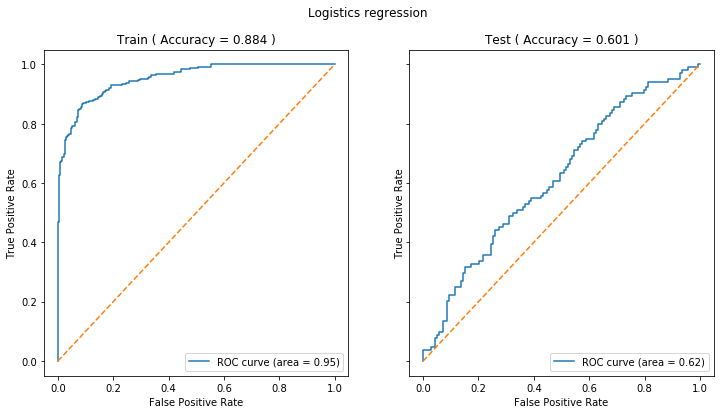

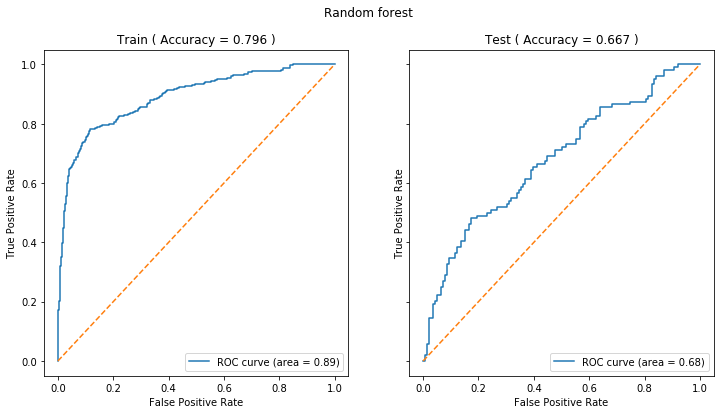

In [5]:
mdoels = fit_models(X_isomap_train, y_train, X_isomap_test, y_test)

# LLE

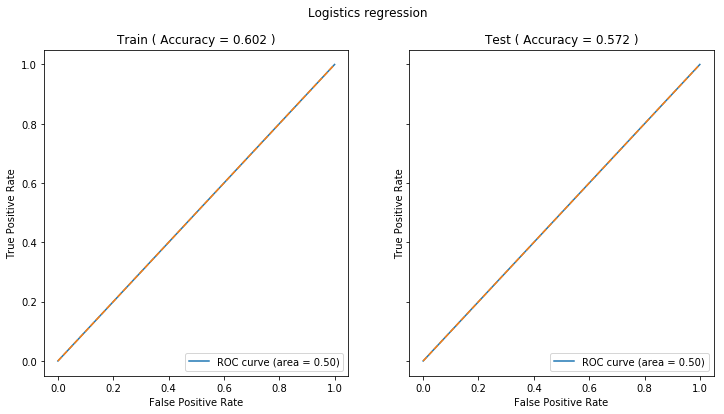

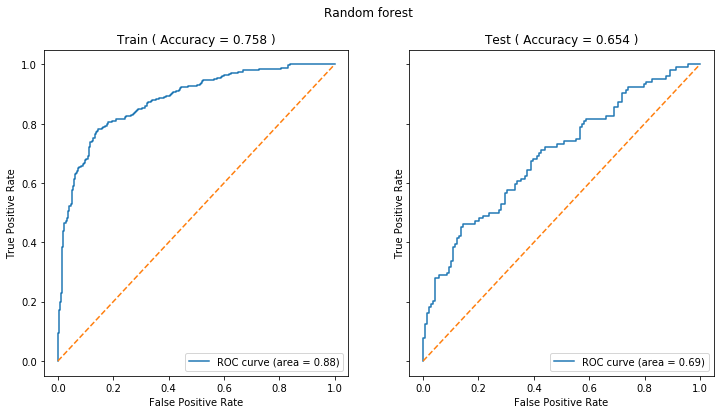

In [6]:
models = fit_models(X_lle_train, y_train, X_lle_test, y_test)

# PCA

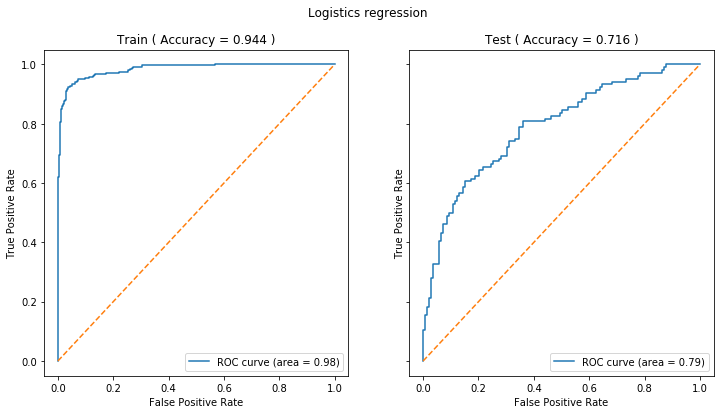

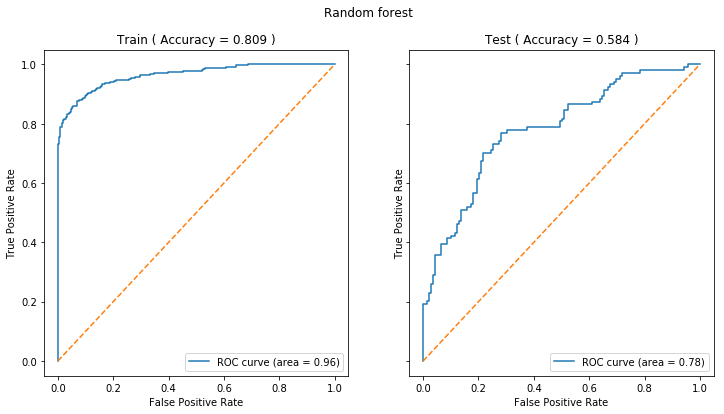

In [7]:
pca_transform = PCA(n_components=250, svd_solver='full').fit(X_std_train)
X_pca_train = pca_transform.transform(X_std_train)
X_pca_test = pca_transform.transform(X_std_test)
models = fit_models(X_pca_train, y_train, X_pca_test, y_test)

# MLCC

In [4]:
mlcc_results = []
filenames = []
for filename in os.listdir('./mlcc_results/'):
    if filename.endswith('.RData'):
        mlcc_results.append(tuple(read_mlcc_result(filename, 726)))
        filenames.append(filename)
print(filenames)
#segmentation, mBIC, dimensionalities = read_mlcc_result(100, 969)

['output500_8_40_30.RData', 'output500_1_40_30.RData', 'output50_4_40_30.RData', 'output50_8_40_30.RData', 'output100_8_40_30.RData', 'output250_1_40_30.RData', 'output150_8_40_30.RData', 'output100_4_40_30.RData', 'output10_8_40_30.RData', 'output75_4_40_30.RData', 'output20_4_40_30.RData', 'output20_8_40_30.RData', 'output200_8_40_30.RData']


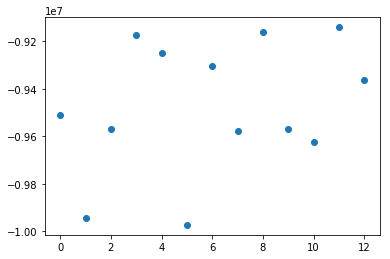

Highest mBIC is from output20_8_40_30.RData


In [5]:
mBICs = list(map(lambda x : x[1][0], mlcc_results))
plt.figure()
plt.scatter(np.arange(len(mBICs)), mBICs)
plt.show()
max_index = np.argmax(mBICs)
print('Highest mBIC is from {}'.format(filenames[max_index]))

In [6]:
segmentation = mlcc_results[max_index][0]
dimensionalities = mlcc_results[max_index][2]
print(segmentation, dimensionalities)
print(len(dimensionalities))

X_mlcc_train = apply_mlcc_dim_reduction(X_std_train, segmentation, dimensionalities)
X_mlcc_test = apply_mlcc_dim_reduction(X_std_test, segmentation, dimensionalities)

[10  5  5 ...  1  7 18] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
20


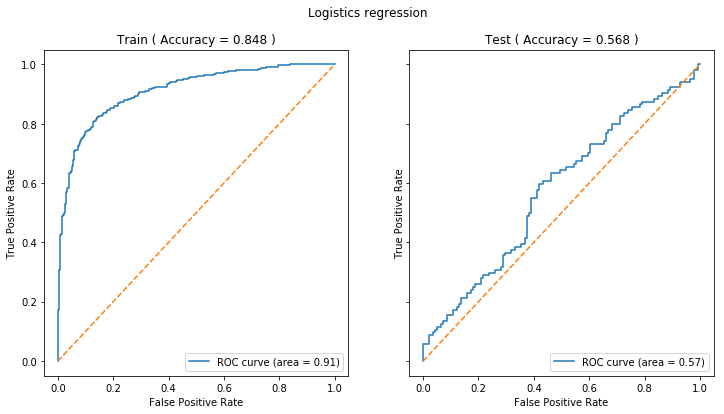

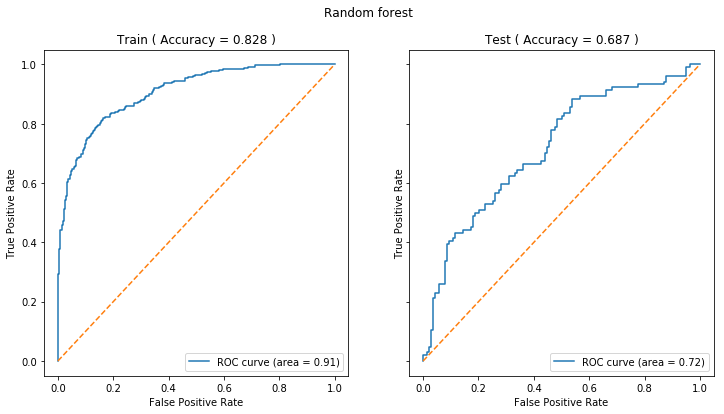

In [7]:
models = fit_models(X_mlcc_train, y_train, X_mlcc_test, y_test)

# SPCA

In [14]:
clf_params = {'C' : [0.1, 0.3, 0.5], 'penalty' : ['l1', 'l2'], 'solver' : ['liblinear']}
dim_params = {'n_components' : [100, 250, 500], 'threshold_val' : [0.1, 0.5, 1, 5, 10]}

spca = SPCWrapper(max_iter=50)
clf = LogisticRegression()

models = fit_dim_reduction_pipeline(spca, clf, dim_params, clf_params, X_std_train, y_train, n_iter=20)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('dim', SPCWrapper(max_iter=50, n_components=500, threshold_val=1)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])


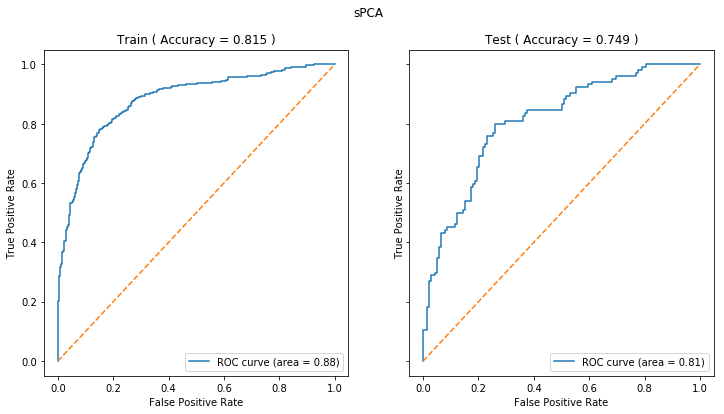

In [15]:
print(models.best_estimator_)
plot_clf_roc(models.best_estimator_, X_std_train, y_train, X_std_test, y_test, 'sPCA')